In [1]:
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(fitdistrplus)
library(bda)
library(arules)

Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

This is bayesplot version 1.5.0
- Plotting theme set to bayesplot::theme_default()
- Online documentation at mc-stan.org/bayesplot
Loading required package: MASS
Loading required package: survival

At

In [2]:
data_path <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
table_path <- "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

In [3]:
get_data <- function(data_path, file_name){
    data <- read.table(file.path(data_path, file_name), header = TRUE, sep = "\t")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])  
    data[, 'task'] <- factor(data[, 'task'])  
    data[, 'session'] <- factor(data[, 'session'])  
    data$AUC <- 1 - data$k

    return(data)
}

In [4]:
get_bf_k <- function(data, var, family, rscale, n=1){
    bfs <- data.frame(double(), double(), double())
    
    for (i in 1:n) {
        # sd(var) in this case is 0.5, as var is task (equal number of 0's and 1's)
        priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class='Intercept'),
                        set_prior(sprintf('cauchy(0.0, %f)', rscale*sd(data[, var])/0.5), class='b'))

        formula_null <- as.formula(paste(var, "~ (1 | subj_id)"))
        formula_task <- as.formula(paste(var, "~ (1 | subj_id) + task"))
        formula_session <- as.formula(paste(var, "~ (1 | subj_id) + session"))
        formula_inter <- as.formula(paste(var, "~ (1 | subj_id) + task*session"))

        m_null <- brm(formula_null, data=data, family=family, save_all_pars=TRUE, prior=priors_task[1,],
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        m_task <- brm(formula_task, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))    
        m_session <- brm(formula_session, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        m_inter <- brm(formula_inter, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                      refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
        
        bf <- t(c(bayes_factor(x1=m_task, x2=m_null)$bf, 
                  bayes_factor(x1=m_session, x2=m_null)$bf, 
                  bayes_factor(x1=m_inter, x2=m_null)$bf))
#         bf_task <- bayes_factor(x1=m_task, x2=m_null)$bf
#         bf_session <- bayes_factor(x1=m_session, x2=m_null)$bf
#         bf_inter <- bayes_factor(x1=m_inter, x2=m_null)$bf

#         names(bf_task) <- 'bf_task'
#         names(bf_session) <- 'bf_session'
#         names(bf_inter) <- 'bf_inter'
        bfs <- rbind(bfs, bf)
    }
    
    colnames(bfs) <- c('bf_task', 'bf_session', 'bf_inter')
    
    # to visualize posteriors, we just use the model fitted last
    result = list(bf=colMeans(bfs),  
                  m_null=m_null, 
                  m_task=m_task, 
                  m_session=m_session,
                  m_inter=m_inter)
    
    return(result)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

show_result <- function(result) {
    print("Bayes factors: ")
    print(result$bf)
    hpd_task<-HPDinterval(as.mcmc(result$m_task, combine_chains = TRUE))
    hpd_session<-HPDinterval(as.mcmc(result$m_session, combine_chains = TRUE))
    print("Credible interval for the task effect (walking relative to mouse): ")
    print(hpd_task['b_taskwalking',])
    print("Credible interval for the session effect (2nd session relative to 1st): ")
    print(hpd_session['b_sessionsecond',])
#     mcmc_areas_ridges(as.matrix(as.mcmc(result$m_bias, combine_chains = TRUE)), regex_pars = "b_task", prob=0.95)
}

# Preregistered analysis

In [5]:
data <- get_data(data_path, "k_values_54.csv")
print(nrow(data))

[1] 108


In [6]:
data

subj_id,task,k,session,sequence,SS_bias,AUC
1322,mouse,0.9325057,first,mw,-0.48821750,0.06749429
1402,mouse,0.9703482,first,mw,0.03046794,0.02965183
1408,mouse,0.3983733,second,wm,0.11081885,0.60162671
1474,mouse,0.8751284,first,mw,-0.04696042,0.12487158
1879,mouse,0.8239869,second,wm,-0.27269836,0.17601313
2045,mouse,0.7232734,first,mw,-0.50074000,0.27672660
2249,mouse,0.9584760,first,mw,-0.60422898,0.04152397
2261,mouse,0.8941924,first,mw,-0.57138308,0.10580765
2752,mouse,0.9527112,second,wm,0.14741077,0.04728881
2758,mouse,0.8964184,second,wm,-0.17682609,0.10358162


Contrary to what was assumed at the time of preregistration, k-values aren't approximated well by the normal distribution. Still, we check Bayes factors according to the originally specified design (`gaussian` family parameter in brms)

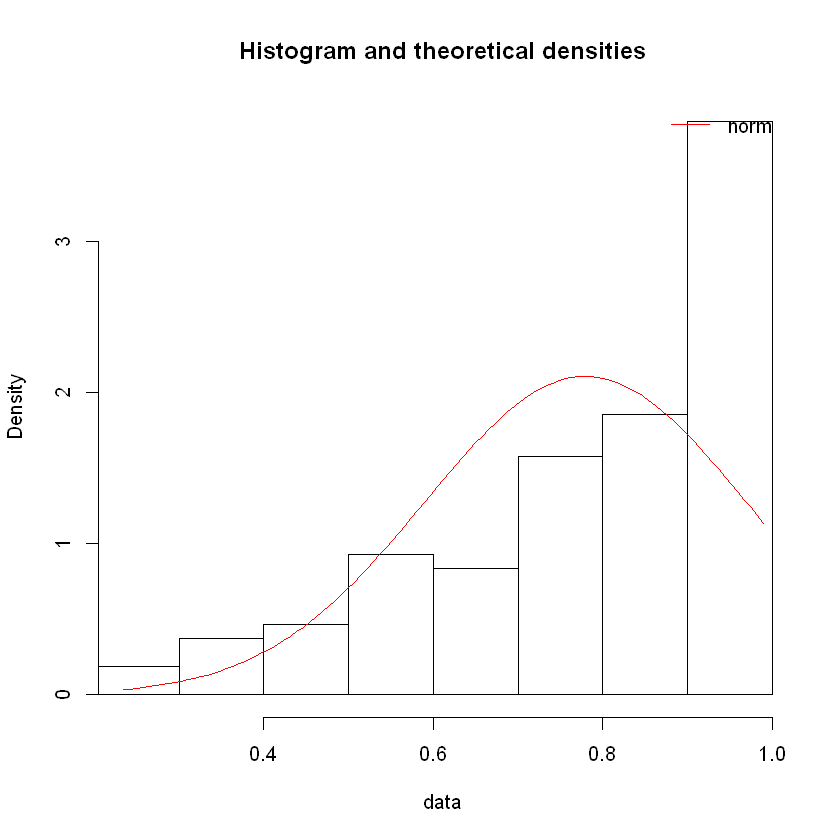

In [7]:
fit_w  <- fitdist(data$k, "norm")
denscomp(fit_w)

In [8]:
prereg_result <- get_bf_k(data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.316 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.449 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.337 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.47 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.343 seconds (Warm-up)
               0.151 seconds (Sampling)
               0.494 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.357 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.461 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.644 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.427 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.609 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.417 seconds (Warm-up)
               0.177 seconds (Sampling)
               0.594 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.437 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.483 seconds (Warm-up)
               0.21 seconds (Sampling)
               0.693 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.516 seconds (Warm-up)
               0.202 seconds (Sampling)
               0.718 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.452 seconds (Warm-up)
               0.204 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.482 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.585 seconds (Warm-up)
               0.424 seconds (Sampling)
               1.009 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.548 seconds (Warm-up)
               0.363 seconds (Sampling)
               0.911 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.556 seconds (Warm-up)
               0.213 seconds (Sampling)
               0.769 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.605 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.334 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.467 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.324 seconds (Warm-up)
               0.139 seconds (Sampling)
               0.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.324 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.466 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.294 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.657 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.431 seconds (Warm-up)
               0.185 seconds (Sampling)
               0.616 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.401 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.574 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.409 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.429 seconds (Warm-up)
               0.195 seconds (Sampling)
               0.624 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.499 seconds (Warm-up)
               0.202 seconds (Sampling)
               0.701 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.426 seconds (Warm-up)
               0.201 seconds (Sampling)
               0.627 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.424 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.528 seconds (Warm-up)
               0.303 seconds (Sampling)
               0.831 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.498 seconds (Warm-up)
               0.341 seconds (Sampling)
               0.839 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.532 seconds (Warm-up)
               0.204 seconds (Sampling)
               0.736 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.515 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.385 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.518 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.35 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.493 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.349 seconds (Warm-up)
               0.144 seconds (Sampling)
               0.493 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.369 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.588 seconds (Warm-up)
               0.233 seconds (Sampling)
               0.821 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.526 seconds (Warm-up)
               0.22 seconds (Sampling)
               0.746 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.496 seconds (Warm-up)
               0.272 seconds (Sampling)
               0.768 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.464 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.505 seconds (Warm-up)
               0.23 seconds (Sampling)
               0.735 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.52 seconds (Warm-up)
               0.223 seconds (Sampling)
               0.743 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.528 seconds (Warm-up)
               0.21 seconds (Sampling)
               0.738 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.485 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.606 seconds (Warm-up)
               0.414 seconds (Sampling)
               1.02 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.55 seconds (Warm-up)
               0.383 seconds (Sampling)
               0.933 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.579 seconds (Warm-up)
               0.375 seconds (Sampling)
               0.954 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.587 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.346 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.519 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.434 seconds (Warm-up)
               0.163 seconds (Sampling)
               0.597 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.404 seconds (Warm-up)
               0.164 seconds (Sampling)
               0.568 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.425 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.506 seconds (Warm-up)
               0.203 seconds (Sampling)
               0.709 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.488 seconds (Warm-up)
               0.22 seconds (Sampling)
               0.708 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.533 seconds (Warm-up)
               0.206 seconds (Sampling)
               0.739 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.553 seconds (Warm-up)
               0.222 seconds (Sampling)
               0.775 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.527 seconds (Warm-up)
               0.212 seconds (Sampling)
               0.739 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.536 seconds (Warm-up)
               0.242 seconds (Sampling)
               0.778 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.516 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.551 seconds (Warm-up)
               0.449 seconds (Sampling)
               1 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.585 seconds (Warm-up)
               0.401 seconds (Sampling)
               0.986 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.616 seconds (Warm-up)
               0.302 seconds (Sampling)
               0.918 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.577 seconds (War

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.364 seconds (Warm-up)
               0.162 seconds (Sampling)
               0.526 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.346 seconds (Warm-up)
               0.162 seconds (Sampling)
               0.508 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.354 seconds (Warm-up)
               0.161 seconds (Sampling)
               0.515 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.354 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.525 seconds (Warm-up)
               0.202 seconds (Sampling)
               0.727 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.489 seconds (Warm-up)
               0.203 seconds (Sampling)
               0.692 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.534 seconds (Warm-up)
               0.201 seconds (Sampling)
               0.735 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.504 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.503 seconds (Warm-up)
               0.206 seconds (Sampling)
               0.709 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.537 seconds (Warm-up)
               0.21 seconds (Sampling)
               0.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.567 seconds (Warm-up)
               0.232 seconds (Sampling)
               0.799 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.509 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.637 seconds (Warm-up)
               0.323 seconds (Sampling)
               0.96 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.525 seconds (Warm-up)
               0.336 seconds (Sampling)
               0.861 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.588 seconds (Warm-up)
               0.397 seconds (Sampling)
               0.985 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.616 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.346 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.499 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.393 seconds (Warm-up)
               0.152 seconds (Sampling)
               0.545 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.416 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.569 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.384 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.468 seconds (Warm-up)
               0.22 seconds (Sampling)
               0.688 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.437 seconds (Warm-up)
               0.213 seconds (Sampling)
               0.65 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.495 seconds (Warm-up)
               0.212 seconds (Sampling)
               0.707 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.532 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.535 seconds (Warm-up)
               0.205 seconds (Sampling)
               0.74 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.508 seconds (Warm-up)
               0.211 seconds (Sampling)
               0.719 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.495 seconds (Warm-up)
               0.224 seconds (Sampling)
               0.719 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.558 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.587 seconds (Warm-up)
               0.344 seconds (Sampling)
               0.931 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.645 seconds (Warm-up)
               0.332 seconds (Sampling)
               0.977 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.737 seconds (Warm-up)
               0.453 seconds (Sampling)
               1.19 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.715 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.371 seconds (Warm-up)
               0.154 seconds (Sampling)
               0.525 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.406 seconds (Warm-up)
               0.163 seconds (Sampling)
               0.569 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.375 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.516 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.367 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.448 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.631 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.471 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.655 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.447 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.639 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.444 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.414 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.596 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.453 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.637 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.456 seconds (Warm-up)
               0.185 seconds (Sampling)
               0.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.48 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.487 seconds (Warm-up)
               0.222 seconds (Sampling)
               0.709 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.509 seconds (Warm-up)
               0.277 seconds (Sampling)
               0.786 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.478 seconds (Warm-up)
               0.235 seconds (Sampling)
               0.713 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.568 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.374 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.507 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.37 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.503 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.322 seconds (Warm-up)
               0.134 seconds (Sampling)
               0.456 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.364 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.425 seconds (Warm-up)
               0.186 seconds (Sampling)
               0.611 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.428 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.612 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.448 seconds (Warm-up)
               0.175 seconds (Sampling)
               0.623 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.418 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.452 seconds (Warm-up)
               0.191 seconds (Sampling)
               0.643 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.459 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.653 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.443 seconds (Warm-up)
               0.202 seconds (Sampling)
               0.645 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.464 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.535 seconds (Warm-up)
               0.374 seconds (Sampling)
               0.909 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.537 seconds (Warm-up)
               0.293 seconds (Sampling)
               0.83 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.518 seconds (Warm-up)
               0.349 seconds (Sampling)
               0.867 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.488 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.384 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.527 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.363 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.505 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.342 seconds (Warm-up)
               0.131 seconds (Sampling)
               0.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.386 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.008 seconds
1000 transitions using 10 leapfrog steps per transition would take 80 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds (Warm-up)
               0.172 seconds (Sampling)
               0.61 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.436 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.63 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.507 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.689 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.414 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.513 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.695 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.397 seconds (Warm-up)
               0.213 seconds (Sampling)
               0.61 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.44 seconds (Warm-up)
               0.195 seconds (Sampling)
               0.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.457 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.488 seconds (Warm-up)
               0.253 seconds (Sampling)
               0.741 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.532 seconds (Warm-up)
               0.326 seconds (Sampling)
               0.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.541 seconds (Warm-up)
               0.255 seconds (Sampling)
               0.796 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.562 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.346 seconds (Warm-up)
               0.186 seconds (Sampling)
               0.532 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.377 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.52 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.344 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.486 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.329 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.484 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.678 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.434 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.626 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.493 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.677 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.418 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.411 seconds (Warm-up)
               0.185 seconds (Sampling)
               0.596 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.455 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.649 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.475 seconds (Warm-up)
               0.181 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.469 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.494 seconds (Warm-up)
               0.364 seconds (Sampling)
               0.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.495 seconds (Warm-up)
               0.311 seconds (Sampling)
               0.806 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.504 seconds (Warm-up)
               0.354 seconds (Sampling)
               0.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.487 seconds 

In [9]:
show_result(prereg_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.073445942 0.275193557 0.005098406 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05058931  0.02765813 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.069444782  0.003507169 


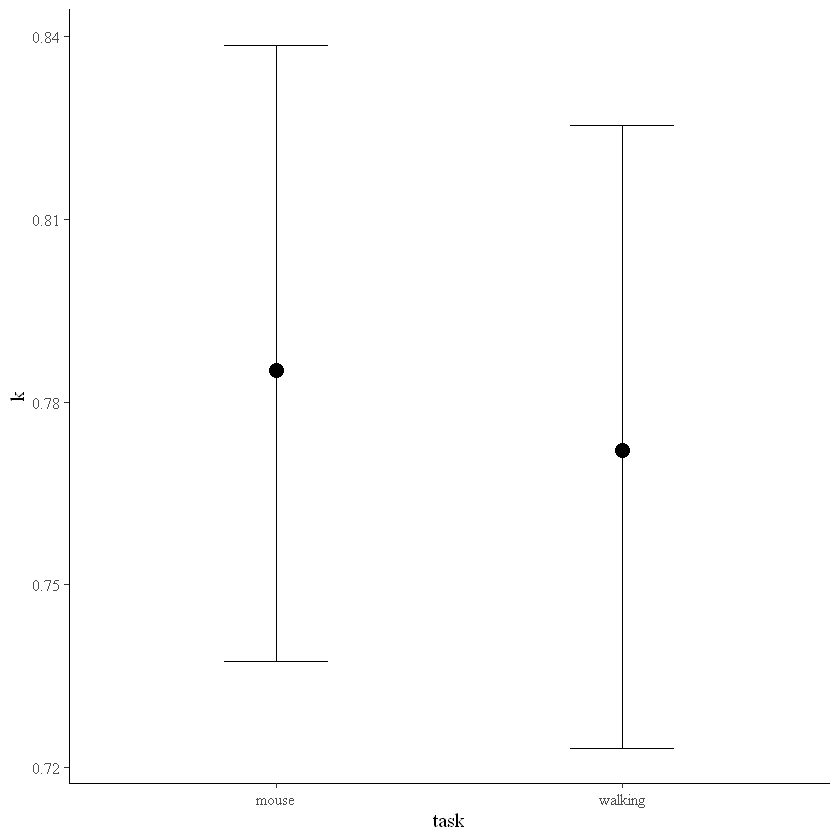

In [10]:
plot(marginal_effects(prereg_result$m_task))

In [11]:
save_posterior(prereg_result$m_task, file_name = sprintf("posterior_%s_%s.%s", "k_task", "prereg", "csv"))

# Exploratory analysis

# Accounting for the observed distribution of $k$

After reaching BF>10 in favor of null model over the model with the main effect of task, we terminated data collection, even though BF of the model with the session effect has not yet reached the designated boundary of 10. The reason was that it became evident that there is no difference in discounting behavior between tasks.  Just in case, we checked that this holds if we change the `family` parameter of the brms regression to `weibull`, as Weibull distribution more closely matches the distribution of k-values (we ran the model on zero-peaked quantity `1-k`)

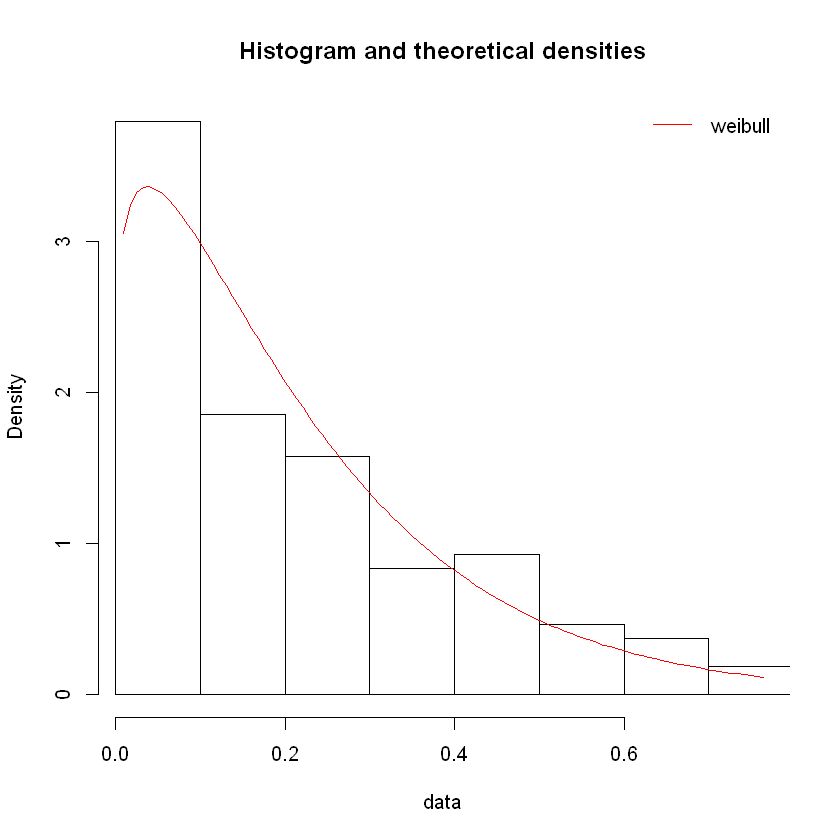

In [12]:
fit_w  <- fitdist(data$AUC, "weibull")
denscomp(fit_w)

In [13]:
AUC_weibull_result <- get_bf_k(data, 'AUC', weibull(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.139 seconds (Warm-up)
               1.774 seconds (Sampling)
               3.913 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.987 seconds (Warm-up)
               1.803 seconds (Sampling)
               3.79 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.901 seconds (Warm-up)
               1.872 seconds (Sampling)
               4.773 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.018 seconds (

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.084 seconds (Warm-up)
               2.371 seconds (Sampling)
               4.455 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.422 seconds (Warm-up)
               2.026 seconds (Sampling)
               4.448 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.183 seconds (Warm-up)
               2.319 seconds (Sampling)
               4.502 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.906 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.603 seconds (Warm-up)
               2.542 seconds (Sampling)
               5.145 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.269 seconds (Warm-up)
               1.894 seconds (Sampling)
               4.163 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.287 seconds (Warm-up)
               2.425 seconds (Sampling)
               4.712 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.182 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.539 seconds (Warm-up)
               1.968 seconds (Sampling)
               4.507 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.264 seconds (Warm-up)
               2.082 seconds (Sampling)
               4.346 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.479 seconds (Warm-up)
               1.954 seconds (Sampling)
               4.433 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.252 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.262 seconds (Warm-up)
               1.779 seconds (Sampling)
               4.041 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.199 seconds (Warm-up)
               1.717 seconds (Sampling)
               3.916 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.178 seconds (Warm-up)
               2.001 seconds (Sampling)
               4.179 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.072 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.45 seconds (Warm-up)
               2.693 seconds (Sampling)
               5.143 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.387 seconds (Warm-up)
               1.993 seconds (Sampling)
               4.38 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.278 seconds (Warm-up)
               1.897 seconds (Sampling)
               4.175 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.174 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.149 seconds (Warm-up)
               1.966 seconds (Sampling)
               4.115 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.302 seconds (Warm-up)
               2.041 seconds (Sampling)
               4.343 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.263 seconds (Warm-up)
               2.024 seconds (Sampling)
               4.287 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.274 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.304 seconds (Warm-up)
               2.018 seconds (Sampling)
               4.322 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.248 seconds (Warm-up)
               1.859 seconds (Sampling)
               4.107 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.492 seconds (Warm-up)
               2.181 seconds (Sampling)
               4.673 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.374 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.227 seconds (Warm-up)
               2.26 seconds (Sampling)
               4.487 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.082 seconds (Warm-up)
               1.755 seconds (Sampling)
               3.837 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.22 seconds (Warm-up)
               2.103 seconds (Sampling)
               4.323 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.178 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.677 seconds (Warm-up)
               1.986 seconds (Sampling)
               4.663 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.512 seconds (Warm-up)
               2.11 seconds (Sampling)
               4.622 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.268 seconds (Warm-up)
               2.246 seconds (Sampling)
               4.514 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.261 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.24 seconds (Warm-up)
               3.326 seconds (Sampling)
               5.566 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.395 seconds (Warm-up)
               2.284 seconds (Sampling)
               4.679 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.275 seconds (Warm-up)
               1.746 seconds (Sampling)
               4.021 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.233 seconds (

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.391 seconds (Warm-up)
               2.134 seconds (Sampling)
               4.525 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.463 seconds (Warm-up)
               2.114 seconds (Sampling)
               4.577 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.286 seconds (Warm-up)
               1.998 seconds (Sampling)
               4.284 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.301 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.112 seconds (Warm-up)
               2.153 seconds (Sampling)
               4.265 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.2 seconds (Warm-up)
               1.825 seconds (Sampling)
               4.025 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.372 seconds (Warm-up)
               1.786 seconds (Sampling)
               4.158 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.219 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.141 seconds (Warm-up)
               1.638 seconds (Sampling)
               3.779 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.344 seconds (Warm-up)
               2.674 seconds (Sampling)
               5.018 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.384 seconds (Warm-up)
               1.971 seconds (Sampling)
               4.355 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.353 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.274 seconds (Warm-up)
               1.883 seconds (Sampling)
               4.157 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.335 seconds (Warm-up)
               1.926 seconds (Sampling)
               4.261 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.572 seconds (Warm-up)
               1.93 seconds (Sampling)
               4.502 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.095 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.368 seconds (Warm-up)
               2.194 seconds (Sampling)
               4.562 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.37 seconds (Warm-up)
               1.93 seconds (Sampling)
               4.3 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.285 seconds (Warm-up)
               1.957 seconds (Sampling)
               4.242 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.275 seconds (War

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.222 seconds (Warm-up)
               1.847 seconds (Sampling)
               4.069 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.249 seconds (Warm-up)
               2.722 seconds (Sampling)
               4.971 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.242 seconds (Warm-up)
               1.747 seconds (Sampling)
               3.989 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.087 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.432 seconds (Warm-up)
               2.264 seconds (Sampling)
               4.696 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.334 seconds (Warm-up)
               1.879 seconds (Sampling)
               4.213 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.284 seconds (Warm-up)
               1.923 seconds (Sampling)
               4.207 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.283 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.161 seconds (Warm-up)
               1.915 seconds (Sampling)
               4.076 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.231 seconds (Warm-up)
               1.856 seconds (Sampling)
               4.087 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.392 seconds (Warm-up)
               1.945 seconds (Sampling)
               4.337 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.272 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.29 seconds (Warm-up)
               1.95 seconds (Sampling)
               4.24 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.251 seconds (Warm-up)
               1.974 seconds (Sampling)
               4.225 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.483 seconds (Warm-up)
               2.189 seconds (Sampling)
               4.672 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.171 seconds (Wa

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.203 seconds (Warm-up)
               1.879 seconds (Sampling)
               4.082 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.103 seconds (Warm-up)
               2.279 seconds (Sampling)
               4.382 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.438 seconds (Warm-up)
               1.951 seconds (Sampling)
               4.389 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.335 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.476 seconds (Warm-up)
               2.511 seconds (Sampling)
               4.987 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.481 seconds (Warm-up)
               1.802 seconds (Sampling)
               4.283 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.677 seconds (Warm-up)
               1.919 seconds (Sampling)
               4.596 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.14 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.44 seconds (Warm-up)
               1.969 seconds (Sampling)
               4.409 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.251 seconds (Warm-up)
               1.96 seconds (Sampling)
               4.211 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.24 seconds (Warm-up)
               1.819 seconds (Sampling)
               4.059 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.542 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.313 seconds (Warm-up)
               2.029 seconds (Sampling)
               4.342 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.395 seconds (Warm-up)
               1.989 seconds (Sampling)
               4.384 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.218 seconds (Warm-up)
               2.899 seconds (Sampling)
               5.117 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.425 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.304 seconds (Warm-up)
               1.711 seconds (Sampling)
               4.015 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.074 seconds (Warm-up)
               1.842 seconds (Sampling)
               3.916 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.189 seconds (Warm-up)
               1.871 seconds (Sampling)
               4.06 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.2 seconds (Wa

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.225 seconds (Warm-up)
               1.86 seconds (Sampling)
               4.085 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.227 seconds (Warm-up)
               2.062 seconds (Sampling)
               4.289 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.364 seconds (Warm-up)
               1.837 seconds (Sampling)
               4.201 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.165 seconds (

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.345 seconds (Warm-up)
               2.068 seconds (Sampling)
               4.413 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.178 seconds (Warm-up)
               1.998 seconds (Sampling)
               4.176 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.277 seconds (Warm-up)
               2.144 seconds (Sampling)
               4.421 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.452 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.331 seconds (Warm-up)
               2.05 seconds (Sampling)
               4.381 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.412 seconds (Warm-up)
               2.952 seconds (Sampling)
               5.364 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.345 seconds (Warm-up)
               2.3 seconds (Sampling)
               4.645 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.071 seconds (Wa

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.217 seconds (Warm-up)
               2.008 seconds (Sampling)
               4.225 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.285 seconds (Warm-up)
               1.906 seconds (Sampling)
               4.191 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.128 seconds (Warm-up)
               1.958 seconds (Sampling)
               4.086 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.148 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.242 seconds (Warm-up)
               1.866 seconds (Sampling)
               4.108 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.645 seconds (Warm-up)
               1.938 seconds (Sampling)
               4.583 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.213 seconds (Warm-up)
               2.11 seconds (Sampling)
               4.323 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.13 seconds (W

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.345 seconds (Warm-up)
               1.671 seconds (Sampling)
               4.016 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.699 seconds (Warm-up)
               1.774 seconds (Sampling)
               4.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.252 seconds (Warm-up)
               2.376 seconds (Sampling)
               4.628 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.575 seconds 

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.438 seconds (Warm-up)
               2.58 seconds (Sampling)
               5.018 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.598 seconds (Warm-up)
               1.999 seconds (Sampling)
               4.597 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.321 seconds (Warm-up)
               2.106 seconds (Sampling)
               4.427 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.637 seconds (

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.266 seconds (Warm-up)
               1.874 seconds (Sampling)
               4.14 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.219 seconds (Warm-up)
               1.866 seconds (Sampling)
               4.085 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.389 seconds (Warm-up)
               2.011 seconds (Sampling)
               4.4 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.753 seconds (Wa

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.014 seconds (Warm-up)
               1.908 seconds (Sampling)
               3.922 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.103 seconds (Warm-up)
               1.902 seconds (Sampling)
               4.005 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.261 seconds (Warm-up)
               1.902 seconds (Sampling)
               4.163 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.248 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.381 seconds (Warm-up)
               1.961 seconds (Sampling)
               4.342 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.366 seconds (Warm-up)
               1.966 seconds (Sampling)
               4.332 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.284 seconds (Warm-up)
               1.928 seconds (Sampling)
               4.212 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.365 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.435 seconds (Warm-up)
               2.02 seconds (Sampling)
               4.455 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.121 seconds (Warm-up)
               2.079 seconds (Sampling)
               4.2 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.433 seconds (Warm-up)
               2.081 seconds (Sampling)
               4.514 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.485 seconds (Wa

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.267 seconds (Warm-up)
               1.796 seconds (Sampling)
               4.063 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.857 seconds (Warm-up)
               1.802 seconds (Sampling)
               3.659 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.162 seconds (Warm-up)
               1.957 seconds (Sampling)
               4.119 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.043 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.188 seconds (Warm-up)
               1.811 seconds (Sampling)
               3.999 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.387 seconds (Warm-up)
               2.284 seconds (Sampling)
               4.671 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.251 seconds (Warm-up)
               1.798 seconds (Sampling)
               4.049 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.328 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.359 seconds (Warm-up)
               1.982 seconds (Sampling)
               4.341 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.428 seconds (Warm-up)
               3.411 seconds (Sampling)
               5.839 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.343 seconds (Warm-up)
               2.073 seconds (Sampling)
               4.416 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.396 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.228 seconds (Warm-up)
               2.167 seconds (Sampling)
               4.395 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.429 seconds (Warm-up)
               2.125 seconds (Sampling)
               4.554 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.956 seconds (Warm-up)
               2.077 seconds (Sampling)
               5.033 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.651 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [14]:
show_result(AUC_weibull_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
 0.3465100  0.7695937  0.1505429 
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1212422  0.2373226 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.03304322  0.32366528 


The Bayes factors in favor of the null model decreased and became less conclusive. We however think that using a modified definition of k-value can help to further clarify whether the task or session afffected k. 

# Using log-delays in calculating k-values

Specifically, as many subjects are close to the head part of the k-value distribution (0.9 to 1.0), we might want to emphasize small differences in discounting curves for these subjects. We can do this by changing the definition of k-value in line with Killeen's additive utility model of delay discounting. Specifically, we use log-scaled delays when calculating k-values (which are recorded to \_log.csv files during preprocessing). 

In [15]:
log_delay_data <- get_data(data_path, "k_values_54_log.csv")
print(nrow(log_delay_data))

[1] 108


These k-values are more normally distributed

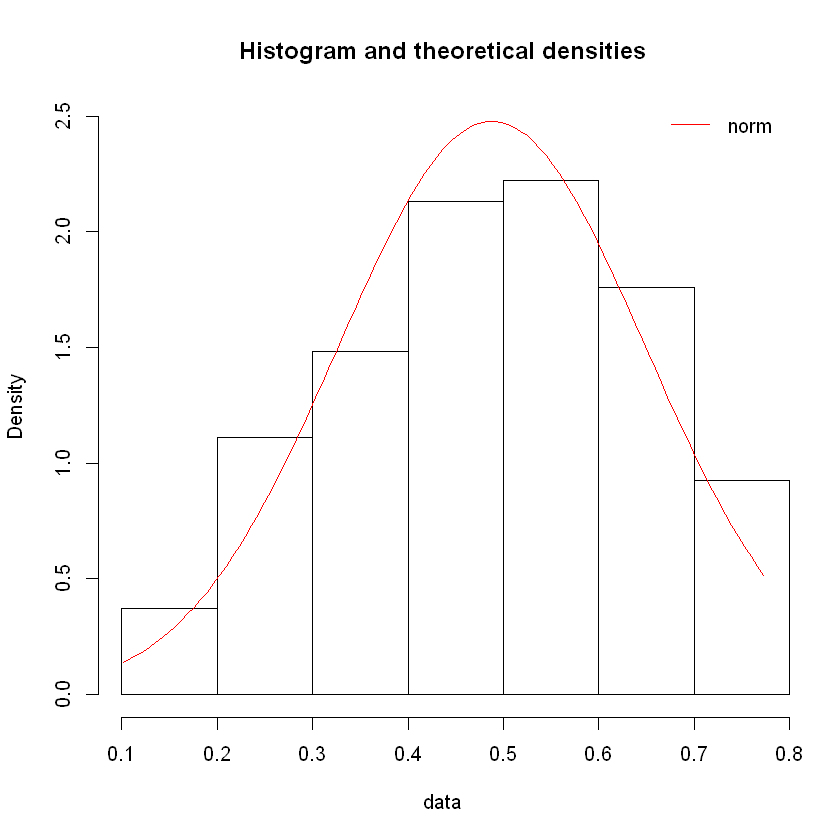

In [16]:
fit_w  <- fitdist(log_delay_data$k, "norm")
denscomp(fit_w)

In [17]:
log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.403 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.536 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.403 seconds (Warm-up)
               0.144 seconds (Sampling)
               0.547 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.422 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.595 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.364 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.539 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.722 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.503 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.697 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.498 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.671 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.527 seconds (Warm-up)
               0.223 seconds (Sampling)
               0.75 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.455 seconds (Warm-up)
               0.213 seconds (Sampling)
               0.668 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.556 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.738 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.533 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.577 seconds (Warm-up)
               0.375 seconds (Sampling)
               0.952 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.667 seconds (Warm-up)
               0.356 seconds (Sampling)
               1.023 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.66 seconds (Warm-up)
               0.337 seconds (Sampling)
               0.997 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.622 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.348 seconds (Warm-up)
               0.152 seconds (Sampling)
               0.5 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.456 seconds (Warm-up)
               0.151 seconds (Sampling)
               0.607 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.415 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.556 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.426 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.522 seconds (Warm-up)
               0.201 seconds (Sampling)
               0.723 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.464 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.513 seconds (Warm-up)
               0.201 seconds (Sampling)
               0.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.493 seconds (Warm-up)
               0.205 seconds (Sampling)
               0.698 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.541 seconds (Warm-up)
               0.212 seconds (Sampling)
               0.753 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.542 seconds (Warm-up)
               0.205 seconds (Sampling)
               0.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.557 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.63 seconds (Warm-up)
               0.374 seconds (Sampling)
               1.004 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.674 seconds (Warm-up)
               0.385 seconds (Sampling)
               1.059 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.566 seconds (Warm-up)
               0.345 seconds (Sampling)
               0.911 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.637 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.365 seconds (Warm-up)
               0.162 seconds (Sampling)
               0.527 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.423 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.576 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.384 seconds (Warm-up)
               0.155 seconds (Sampling)
               0.539 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.406 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.423 seconds (Warm-up)
               0.2 seconds (Sampling)
               0.623 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.568 seconds (Warm-up)
               0.193 seconds (Sampling)
               0.761 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.453 seconds (Warm-up)
               0.195 seconds (Sampling)
               0.648 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.501 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.519 seconds (Warm-up)
               0.193 seconds (Sampling)
               0.712 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.488 seconds (Warm-up)
               0.193 seconds (Sampling)
               0.681 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.49 seconds (Warm-up)
               0.214 seconds (Sampling)
               0.704 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.455 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.599 seconds (Warm-up)
               0.392 seconds (Sampling)
               0.991 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.597 seconds (Warm-up)
               0.382 seconds (Sampling)
               0.979 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.585 seconds (Warm-up)
               0.382 seconds (Sampling)
               0.967 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.613 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.367 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.509 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.368 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.51 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.414 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.567 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.325 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.477 seconds (Warm-up)
               0.187 seconds (Sampling)
               0.664 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.452 seconds (Warm-up)
               0.181 seconds (Sampling)
               0.633 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.468 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.651 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.511 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.446 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.63 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.46 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.644 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.47 seconds (Warm-up)
               0.176 seconds (Sampling)
               0.646 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.479 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.605 seconds (Warm-up)
               0.39 seconds (Sampling)
               0.995 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.569 seconds (Warm-up)
               0.206 seconds (Sampling)
               0.775 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.568 seconds (Warm-up)
               0.314 seconds (Sampling)
               0.882 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.641 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.363 seconds (Warm-up)
               0.132 seconds (Sampling)
               0.495 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.397 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.53 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.387 seconds (Warm-up)
               0.132 seconds (Sampling)
               0.519 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.378 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.64 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.49 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.674 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.464 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.489 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.521 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.713 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.504 seconds (Warm-up)
               0.243 seconds (Sampling)
               0.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.516 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.64 seconds (Warm-up)
               0.347 seconds (Sampling)
               0.987 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.575 seconds (Warm-up)
               0.398 seconds (Sampling)
               0.973 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.633 seconds (Warm-up)
               0.359 seconds (Sampling)
               0.992 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.536 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.407 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.56 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.364 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.497 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.363 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.504 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.371 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.487 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.66 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.483 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.657 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.551 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.724 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.476 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.469 seconds (Warm-up)
               0.177 seconds (Sampling)
               0.646 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.469 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.653 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.64 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.44 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.571 seconds (Warm-up)
               0.386 seconds (Sampling)
               0.957 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.583 seconds (Warm-up)
               0.296 seconds (Sampling)
               0.879 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.571 seconds (Warm-up)
               0.37 seconds (Sampling)
               0.941 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.645 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.374 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.517 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.374 seconds (Warm-up)
               0.14 seconds (Sampling)
               0.514 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.353 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.494 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.384 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.436 seconds (Warm-up)
               0.181 seconds (Sampling)
               0.617 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.468 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.501 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.674 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.451 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.407 seconds (Warm-up)
               0.204 seconds (Sampling)
               0.611 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.579 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.752 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.469 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.661 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.444 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.586 seconds (Warm-up)
               0.378 seconds (Sampling)
               0.964 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.572 seconds (Warm-up)
               0.367 seconds (Sampling)
               0.939 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.57 seconds (Warm-up)
               0.369 seconds (Sampling)
               0.939 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.572 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.412 seconds (Warm-up)
               0.151 seconds (Sampling)
               0.563 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.358 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.501 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.345 seconds (Warm-up)
               0.135 seconds (Sampling)
               0.48 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.354 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.46 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.643 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.621 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.449 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.623 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.47 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.473 seconds (Warm-up)
               0.185 seconds (Sampling)
               0.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.523 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.697 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.492 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.686 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.458 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.621 seconds (Warm-up)
               0.404 seconds (Sampling)
               1.025 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.692 seconds (Warm-up)
               0.406 seconds (Sampling)
               1.098 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.573 seconds (Warm-up)
               0.377 seconds (Sampling)
               0.95 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.574 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.344 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.486 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.359 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.5 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.359 seconds (Warm-up)
               0.153 seconds (Sampling)
               0.512 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.355 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.478 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.662 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.45 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.633 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.476 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.503 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.676 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.458 seconds (Warm-up)
               0.18 seconds (Sampling)
               0.638 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.489 seconds (Warm-up)
               0.205 seconds (Sampling)
               0.694 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.484 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.647 seconds (Warm-up)
               0.414 seconds (Sampling)
               1.061 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.598 seconds (Warm-up)
               0.333 seconds (Sampling)
               0.931 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.61 seconds (Warm-up)
               0.274 seconds (Sampling)
               0.884 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.598 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.334 seconds (Warm-up)
               0.139 seconds (Sampling)
               0.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.376 seconds (Warm-up)
               0.155 seconds (Sampling)
               0.531 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.372 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.505 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.375 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.469 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.661 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.509 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.701 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.479 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.466 seconds (Warm-up)
               0.243 seconds (Sampling)
               0.709 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.475 seconds (Warm-up)
               0.175 seconds (Sampling)
               0.65 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.498 seconds (Warm-up)
               0.177 seconds (Sampling)
               0.675 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.421 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.56 seconds (Warm-up)
               0.376 seconds (Sampling)
               0.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.561 seconds (Warm-up)
               0.365 seconds (Sampling)
               0.926 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.567 seconds (Warm-up)
               0.242 seconds (Sampling)
               0.809 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.612 seconds (

In [18]:
show_result(log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session     bf_inter 
  0.07507177 241.52445226   4.42521784 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04784075  0.01841130 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.08934127 -0.03477077 


# Saving results to a table

In [1]:
save_bf_table <- function(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name){
    hyp_2_format_string <- "\\begin{table}[]
                \\centering
                \\sisetup{round-mode=places, round-precision=1, scientific-notation=false}
                \\caption{%s}
                \\label{%s}
                \\begin{tabular}{@{}lll@{}}
                \\toprule
                dependent variable & $\\textrm{M}_{\\textrm{task}}$ & $\\textrm{M}_{\\textrm{session}}$ \\\\ \\midrule
                $k \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k \\sim ~ \\textrm{Weibull}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k_{\\log} \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & \\num{%g}\\\\ \\bottomrule
                \\end{tabular}
                \\end{table}"
    
    output <- sprintf(hyp_2_format_string, caption, label, 
                      1/prereg_result$bf[1], 1/prereg_result$bf[2], 
                      1/AUC_weibull_result$bf[1], 1/AUC_weibull_result$bf[2], 
                      1/log_delay_result$bf[1], log_delay_result$bf[2])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [2]:
caption = "Results of testing Hypothesis 2: Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf"
file_name = "hyp_2_bf.tex"

save_bf_table(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name)

# Checking the effect of rscale

In [20]:
get_all_results <- function(rscale){
    prereg_result <- get_bf_k(data, 'k', gaussian(), rscale)
    AUC_Weibull_result <- get_bf_k(data, 'k', weibull(), rscale)
    log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), rscale)
    
    result = list(prereg_result=prereg_result,  
                  AUC_Weibull_result=AUC_Weibull_result, 
                  log_delay_result=log_delay_result)
    
    return(result)
}

### Narrower priors (rscale = 0.5)

In [21]:
narrow_prior_results <- get_all_results(rscale = 0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.356 seconds (Warm-up)
               0.131 seconds (Sampling)
               0.487 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.314 seconds (Warm-up)
               0.132 seconds (Sampling)
               0.446 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.325 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.466 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.332 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.422 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.606 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.661 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.459 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.4 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.433 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.615 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.417 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.6 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.482 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.665 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.457 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.514 seconds (Warm-up)
               0.204 seconds (Sampling)
               0.718 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.509 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.703 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.548 seconds (Warm-up)
               0.212 seconds (Sampling)
               0.76 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.499 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.674 seconds (Warm-up)
               1.031 seconds (Sampling)
               3.705 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.593 seconds (Warm-up)
               1.385 seconds (Sampling)
               3.978 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.624 seconds (Warm-up)
               1.346 seconds (Sampling)
               3.97 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.812 seconds (

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.088 seconds (Warm-up)
               1.246 seconds (Sampling)
               4.334 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.938 seconds (Warm-up)
               2.094 seconds (Sampling)
               5.032 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.559 seconds (Warm-up)
               2.068 seconds (Sampling)
               4.627 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.125 seconds 

Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.664 seconds (Warm-up)
               4.297 seconds (Sampling)
               6.961 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.871 seconds (Warm-up)
               1.44 seconds (Sampling)
               4.311 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.233 seconds (Warm-up)
               1.257 seconds (Sampling)
               3.49 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.682 seconds (W

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.209 seconds (Warm-up)
               1.625 seconds (Sampling)
               4.834 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.275 seconds (Warm-up)
               1.78 seconds (Sampling)
               4.055 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.042 seconds (Warm-up)
               1.432 seconds (Sampling)
               5.474 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.989 seconds (

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.336 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.479 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.353 seconds (Warm-up)
               0.144 seconds (Sampling)
               0.497 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.364 seconds (Warm-up)
               0.15 seconds (Sampling)
               0.514 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.375 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.483 seconds (Warm-up)
               0.172 seconds (Sampling)
               0.655 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.563 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.746 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.444 seconds (Warm-up)
               0.191 seconds (Sampling)
               0.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.494 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.464 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.445 seconds (Warm-up)
               0.171 seconds (Sampling)
               0.616 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.429 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.54 seconds (Warm-up)
               0.367 seconds (Sampling)
               0.907 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.563 seconds (Warm-up)
               0.376 seconds (Sampling)
               0.939 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.578 seconds (Warm-up)
               0.382 seconds (Sampling)
               0.96 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.545 seconds (W

In [22]:
show_result(narrow_prior_results$prereg_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
0.10255271 0.39872154 0.01276068 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05121354  0.02823249 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.070210230  0.005252032 


In [23]:
show_result(narrow_prior_results$AUC_Weibull_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
0.14728980 0.17132106 0.01090537 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.07157938  0.03782903 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.08051761  0.02378405 


In [24]:
show_result(narrow_prior_results$log_delay_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
  0.104393 318.806904   9.342890 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04461438  0.01901375 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09020372 -0.03349721 


### Wider priors

In [25]:
wide_prior_results <- get_all_results(rscale = 1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.341 seconds (Warm-up)
               0.141 seconds (Sampling)
               0.482 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.337 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.479 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.327 seconds (Warm-up)
               0.143 seconds (Sampling)
               0.47 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.347 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds (Warm-up)
               0.197 seconds (Sampling)
               0.671 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.436 seconds (Warm-up)
               0.204 seconds (Sampling)
               0.64 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.386 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.568 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.436 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.444 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.617 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.466 seconds (Warm-up)
               0.181 seconds (Sampling)
               0.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.435 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.617 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.479 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.635 seconds (Warm-up)
               0.407 seconds (Sampling)
               1.042 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.532 seconds (Warm-up)
               0.29 seconds (Sampling)
               0.822 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.608 seconds (Warm-up)
               0.304 seconds (Sampling)
               0.912 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.625 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.623 seconds (Warm-up)
               1.099 seconds (Sampling)
               3.722 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.473 seconds (Warm-up)
               3.953 seconds (Sampling)
               6.426 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.165 seconds (Warm-up)
               1.236 seconds (Sampling)
               4.401 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.318 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.932 seconds (Warm-up)
               1.541 seconds (Sampling)
               4.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.381 seconds (Warm-up)
               1.932 seconds (Sampling)
               4.313 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.505 seconds (Warm-up)
               1.541 seconds (Sampling)
               4.046 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.305 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.995 seconds (Warm-up)
               1.334 seconds (Sampling)
               4.329 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.809 seconds (Warm-up)
               1.211 seconds (Sampling)
               3.02 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.019 seconds (Warm-up)
               2.054 seconds (Sampling)
               5.073 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.998 seconds (

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.925 seconds (Warm-up)
               4.048 seconds (Sampling)
               6.973 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.226 seconds (Warm-up)
               1.738 seconds (Sampling)
               4.964 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.683 seconds (Warm-up)
               1.764 seconds (Sampling)
               5.447 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.864 seconds 

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.343 seconds (Warm-up)
               0.161 seconds (Sampling)
               0.504 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.353 seconds (Warm-up)
               0.14 seconds (Sampling)
               0.493 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.353 seconds (Warm-up)
               0.172 seconds (Sampling)
               0.525 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.333 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.486 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.659 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.489 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.681 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.449 seconds (Warm-up)
               0.181 seconds (Sampling)
               0.63 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.45 seconds (Warm-up)
               0.193 seconds (Sampling)
               0.643 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.47 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.653 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.48 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.653 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.499 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.585 seconds (Warm-up)
               0.384 seconds (Sampling)
               0.969 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.595 seconds (Warm-up)
               0.371 seconds (Sampling)
               0.966 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.574 seconds (Warm-up)
               0.376 seconds (Sampling)
               0.95 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.644 seconds (

In [26]:
show_result(wide_prior_results$prereg_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.052379372 0.204514534 0.002061445 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05223325  0.02553077 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.071206120  0.003673778 


In [27]:
show_result(wide_prior_results$AUC_Weibull_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.057032723 0.097977159 0.001637727 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.06923932  0.04001870 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
     lower      upper 
-0.0833504  0.0272220 


In [28]:
show_result(wide_prior_results$log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session     bf_inter 
  0.05754992 187.83835073   1.90125918 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04375786  0.02227391 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09067880 -0.03555977 


# Saving sensitivity analysis results to separate tables

In [ ]:
caption = "Results of sensitivity analysis of testing Hypothesis 2: Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses for "
label = "tab:hyp_2_bf_narrow"
file_name = "hyp_2_bf_narrow.tex"

save_bf_table(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name)

# Saving everything to RData file

In [29]:
save.image()